In [7]:
from config.config import *
from reading import read_tissue, get_project_info
import pegasus as pg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
project = "tabula_muris"
tissue = "Lung"

In [3]:
is_human, annotations = get_project_info(project, tissue=tissue)
adata = read_tissue(project, tissue, annotations)

2021-05-18 18:39:16,020 - pegasusio.text_utils - INFO - Detected mtx file in 10x v2 format.
2021-05-18 18:39:30,435 - pegasusio.readwrite - INFO - mtx file '/Volumes/scqc/data/mouse/tabula_muris/Lung/Lung-10X_P7_8/matrix.mtx' is loaded.
2021-05-18 18:39:30,435 - pegasusio.readwrite - INFO - Function 'read_input' finished in 21.00s.
2021-05-18 18:39:34,366 - pegasusio.text_utils - INFO - Detected mtx file in 10x v2 format.
2021-05-18 18:39:56,532 - pegasusio.readwrite - INFO - mtx file '/Volumes/scqc/data/mouse/tabula_muris/Lung/Lung-10X_P7_9/matrix.mtx' is loaded.
2021-05-18 18:39:56,532 - pegasusio.readwrite - INFO - Function 'read_input' finished in 26.10s.
2021-05-18 18:40:01,305 - pegasusio.text_utils - INFO - Detected mtx file in 10x v2 format.
2021-05-18 18:40:11,423 - pegasusio.readwrite - INFO - mtx file '/Volumes/scqc/data/mouse/tabula_muris/Lung/Lung-10X_P8_12/matrix.mtx' is loaded.
2021-05-18 18:40:11,424 - pegasusio.readwrite - INFO - Function 'read_input' finished in 14.47

In [4]:
cells = pd.read_csv("/Volumes/scqc/output_pg/" + project + "/" + tissue + "/1.4-mad-2/!cells.csv")

In [5]:
adata.obs["retained"] = False
adata.obs.loc[cells["barcodekey"], "retained"] = True
adata.obs["passed_qc"] = (adata.obs.retained)
pg.filter_data(adata)

2021-05-18 18:40:58,171 - pegasusio.qc_utils - INFO - After filtration, 15859 out of 2949120 cell barcodes are kept in UnimodalData object GRCm38-rna.
2021-05-18 18:40:58,172 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 0.23s.


In [8]:
cells.index = cells.barcodekey
adata.obs["louvain_labels"] = cells.louvain_labels.astype("category")
x_umap = np.array([[cells.umap1[i], cells.umap2[i]] for i in range(len(cells.umap1))], dtype="float32")
adata.obsm["X_umap"] = x_umap

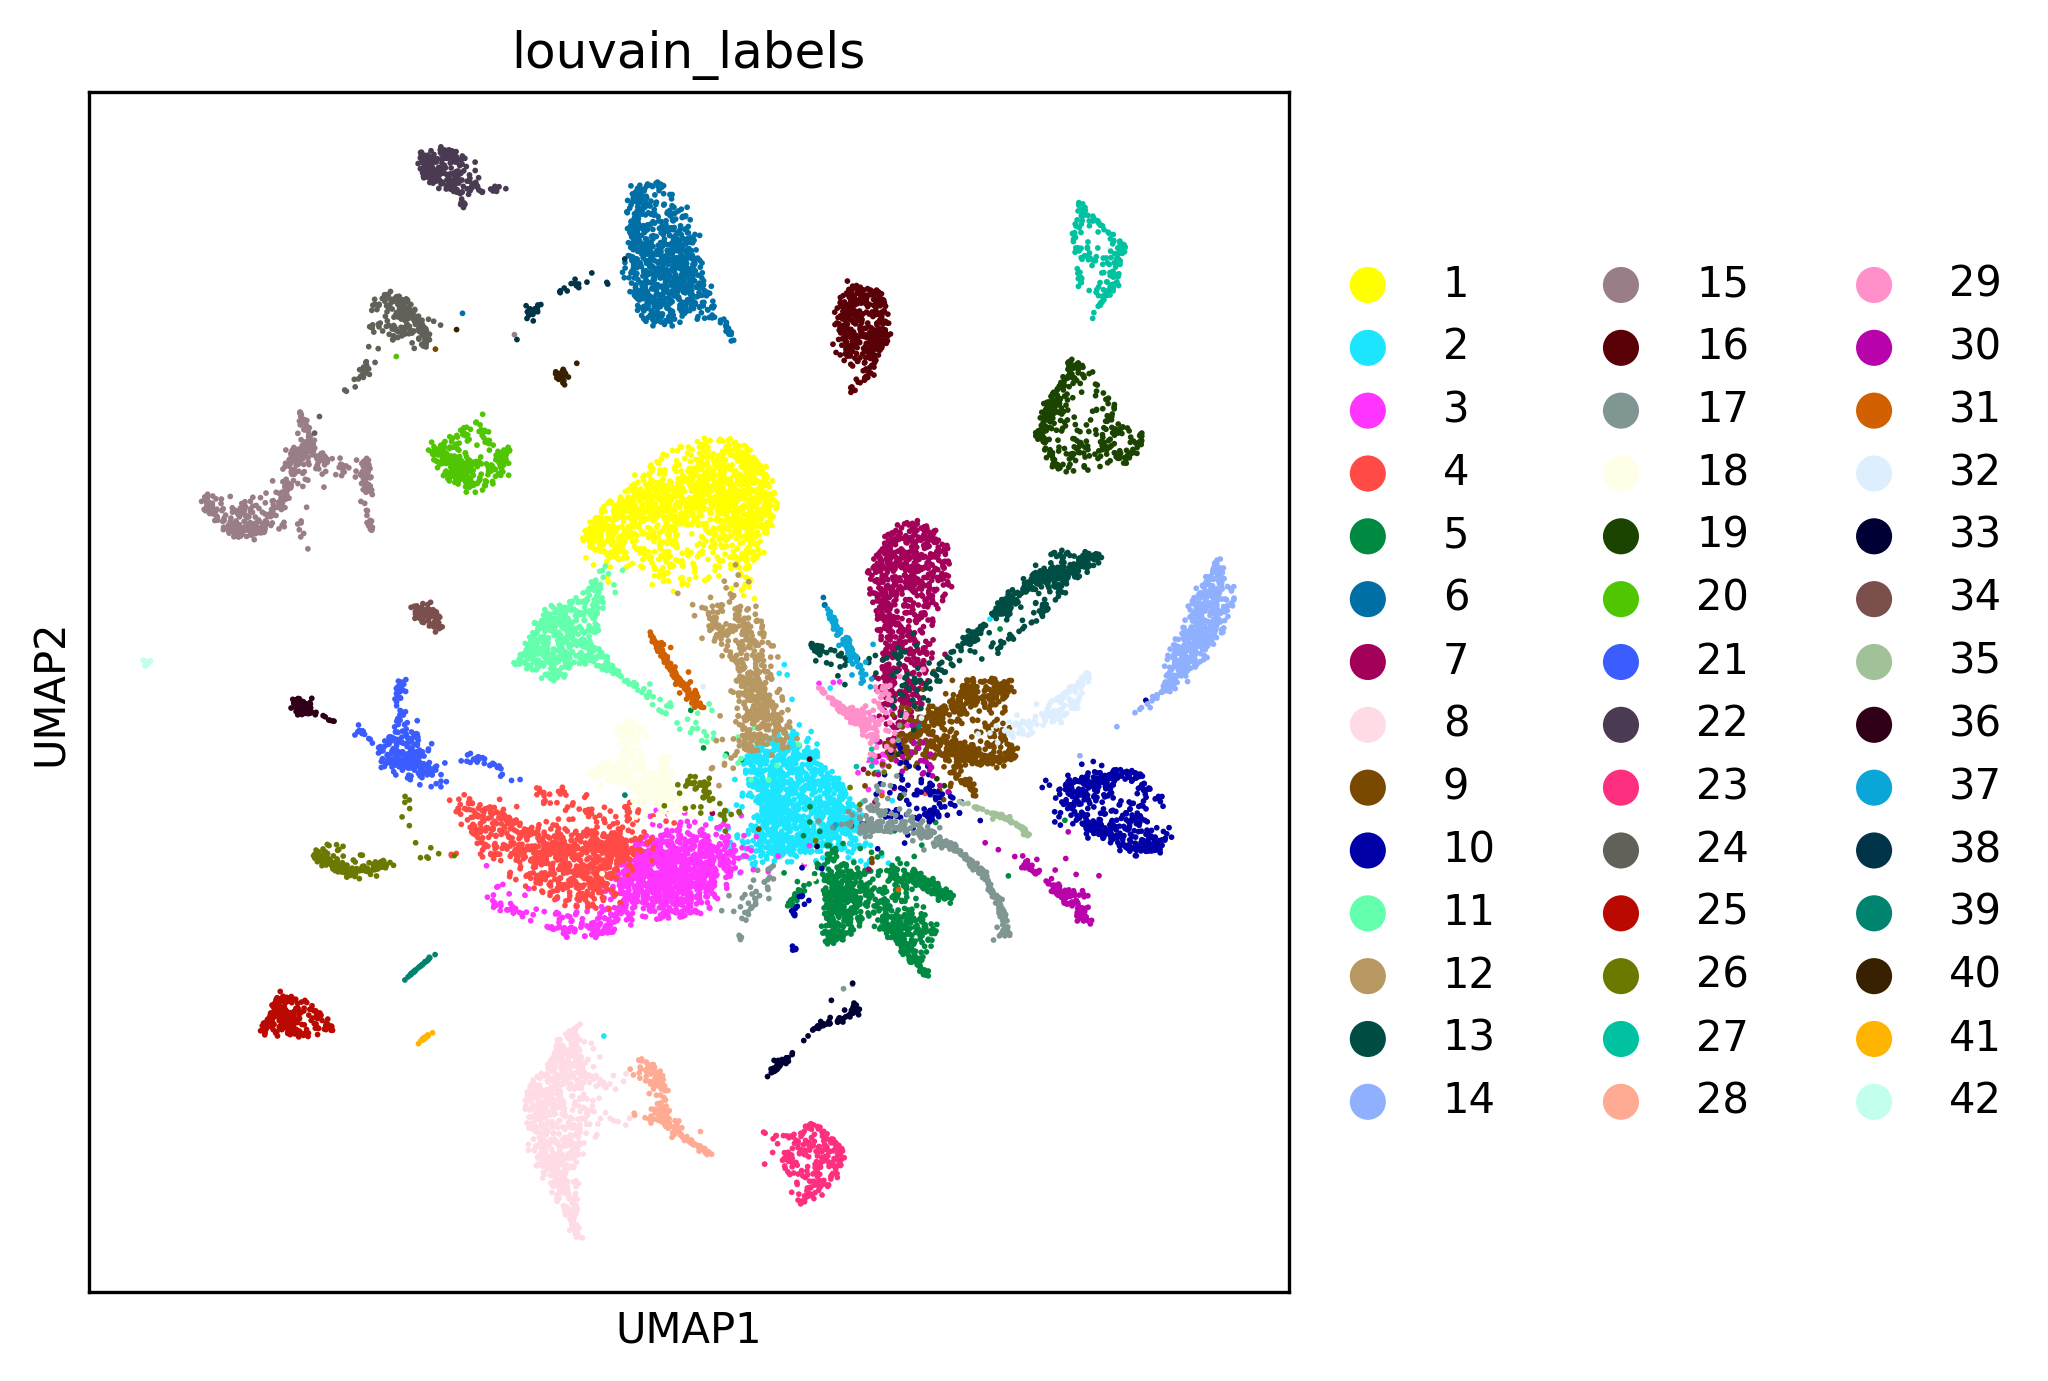

In [10]:
pg.scatter(adata, attrs=['louvain_labels'], basis='umap')

In [13]:
adata.to_anndata().write("test.h5ad")

... storing 'annotations' as categorical


In [ ]:
markers = {"Muscle": ["Nppa", "Myl7", "Myl4", "Sln", "Tpm1", "Tnni3", "Tnnt2", "Atp2a2", "Myh6", "Ttn", "Actc1"],
             "Neutrophil": ["Elane", "Prtn3", "Mpo", "Plac8", "Ctsg", "Ly6c2", "S100a8", "H2afz", "Hmgb2", "Gpx1", "Ptma"],
             "NK cells": ["Ccl5", "Gzma", "Nkg7", "AW112010", "Tyrobp", "Klra4", "Cd52", "Malat1", "Klre1", "Fcer1g", "Tmsb4x", "Actb", "Irf8", "Rac2"],
             "Gamma-delta": ["Trbc2", "Hmgb2", "Stmn1", "H2afz", "Ptma", "Trbc1", "Ppia", "Ran"]}

In [ ]:
pg.identify_robust_genes(adata)
pg.log_norm(adata)
pg.de_analysis(adata, cluster='louvain_labels', t=True, fisher=False, temp_folder="/tmp")

In [ ]:
pg.calc_signature_score(adata, markers)

In [ ]:
fig = pg.violin(adata, attrs=list(markers.keys()), groupby="louvain_labels", color="white", return_fig=True, panel_size=(8, 1))
fig = fig.get_figure()
fig.savefig("/Users/michaelalperovich/Downloads/violin_scores.pdf", bbox_inches='tight')

In [ ]:
for k in markers.keys():
    fig = pg.heatmap(adata, attrs=markers[k], groupby='louvain_labels', groupby_cluster=False, return_fig=True)
    fig.get_figure().savefig(f"/Users/michaelalperovich/Downloads/{k}.pdf", bbox_inches='tight')

In [ ]:
with open("lung.csv", "w") as fout:
    fout.write(adata.obs.to_csv())